# Basic Exploratory Analyses

In [148]:
# imports
import matplotlib.pyplot as plt
# Enables plots within iPython notebooks
%matplotlib inline
import numpy as np
import pandas as pd
import re
import seaborn as sns
import os
import urllib

In [5]:
# From Spencer's code: grab file if local, else DL from URL
FILE_PATH = 'Street_Tree_List.csv'
DATA_SOURCE_URL = 'https://data.sfgov.org/api/views/tkzw-k3nq/rows.csv?accessType=DOWNLOAD'

# Load from interwebs
if not os.path.isfile(FILE_PATH):
    urllib.urlretrieve (DATA_SOURCE_URL, FILE_PATH)
    
df_trees = pd.read_csv(FILE_PATH)

In [15]:
# What do the data look like?
df_trees.head()

,TreeID,qLegalStatus,qSpecies,qAddress,SiteOrder,qSiteInfo,PlantType,qCaretaker,qCareAssistant,PlantDate,DBH,PlotSize,PermitNotes,XCoord,YCoord,Latitude,Longitude,Location
0,119263,DPW Maintained,Pinus radiata :: Monterey Pine,495X Lakeshore Dr,1.0,Median : Yard,Tree,DPW,NaN,NaN,NaN,10x30,NaN,NaN,NaN,NaN,NaN,NaN
1,110785,Permitted Site,Tree(s) ::,2 Edna St,2.0,Front Yard : Yard,Tree,Private,NaN,05/06/2015 12:00:00 AM,3.0,NaN,NaN,5.998788e+06,2.092980e+06,37.726855,-122.446410,"(37.7268545527586, -122.446410203741)"
2,54416,Permitted Site,Tree(s) ::,1434 10th Ave,1.0,Sidewalk: Curb side : Cutout,Tree,Private,NaN,06/19/1972 12:00:00 AM,NaN,NaN,Permit Number 10189,5.993066e+06,2.105706e+06,37.761468,-122.467117,"(37.761468352883, -122.467116526016)"
3,10983,DPW Maintained,Metrosideros excelsa :: New Zealand Xmas Tree,1481 Hudson Ave,1.0,Sidewalk: Curb side : Cutout,Tree,DPW,NaN,NaN,12.0,3X4,NaN,6.016322e+06,2.096940e+06,37.738713,-122.386072,"(37.7387133435699, -122.386072072848)"
4,94164,Permitted Site,Arbutus 'Marina' :: Hybrid Strawberry Tree,729 Lawton St,1.0,Sidewalk: Curb side : Cutout,Tree,Private,NaN,06/15/2010 12:00:00 AM,NaN,3x3,Permit Number 53529,5.991968e+06,2.104568e+06,37.758281,-122.470832,"(37.7582806084367, -122.470831686794)"


In [20]:
# How many rows, columns?
df_trees.shape

(92407, 18)

In [21]:
df_trees['TreeID'].nunique()

92407

No duplicate tree IDs in our records

# Data Hygiene Questions

In [19]:
# What kind of missing data are we dealing with?
df_trees.isnull().sum().sort_values(ascending=False)

qCareAssistant    68337
DBH               53482
PermitNotes       43211
PlotSize          41495
PlantDate         31223
Longitude          2419
Location           2419
XCoord             2419
YCoord             2419
Latitude           2419
qAddress           1490
SiteOrder          1405
qLegalStatus         56
qCaretaker            0
PlantType             0
qSiteInfo             0
qSpecies              0
TreeID                0
dtype: int64

We can immediately see that roughly **2/3 of our plants don't have a care assistant (does the city, or FUF manage these, if there's no designated assistant?)**

There's also **no planting date recorded for roughly 1/3 of the plants**. Do these exist in another database, or are the trees from before the FUF's data collection?

Luckily, we have tree ID's, and species, assigned to all trees! Let's dig into those data more.

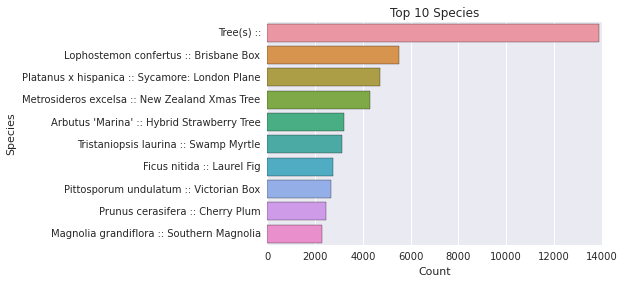

In [104]:
# Group trees by species, get a count descending to find the top 10
# most populus species managed by FUF, and plot it
top10Species = df_trees.groupby(['qSpecies'])[['qSpecies']].count().add_suffix('_count'). \
  sort_values(by="qSpecies_count",ascending=False).reset_index().head(10)
ax = sns.barplot(y="qSpecies",x="qSpecies_count",data=top10Species)
ax.set(xlabel="Count", ylabel="Species", title="Top 10 Species")

**About 15% of the trees in the dataset have a qSpecies of "Tree(s) ::" , which appear to indicate missing species**. How many of these have a Location, such that we could identify them? Is that important?

In [105]:
# Are there other values that indicate missing species?
list_of_species = df_trees['qSpecies'].unique()
# FIRST PASS: If we have a pattern that doesn't have alphanumeric characters, we have a bad species
bad_species_pattern = re.compile(r'([^a-zA-Z]+)')
# If we have any species that match the above pattern, or if we have an empty string
# for the species name, store these and print. This list is non-exhaustive. There may
# be other species misspelled, etc., and may not qualify as proper species names
bad_species = [species for species in list_of_species if bad_species_pattern.match(species) or species == '']
print("Original Bad Species: %s" % bad_species)
# Finally, add the species we saw above to our "bad species" list
bad_species.append("Tree(s) ::")
print("After additions: %s" % bad_species)

Original Bad Species: ['::']
After additions: ['::', 'Tree(s) ::']


In [107]:
# Now, filter the records with bad species out, for this specific analysis, and continue
df_good_species = df_trees[~df_trees.qSpecies.isin(bad_species)]
df_good_species.shape

(78508, 18)

This removed about 14,000 records, as expected

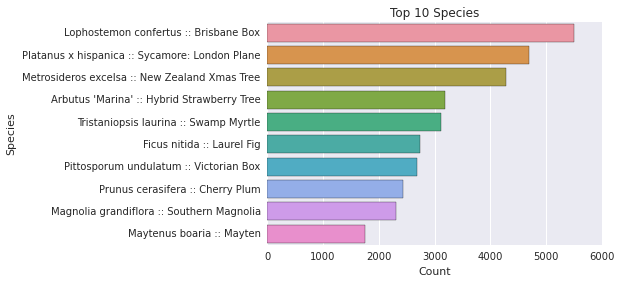

In [108]:
# Let's plot the top 10 species again, and move on
top10Species = df_good_species.groupby(['qSpecies'])[['qSpecies']].count().add_suffix('_count'). \
  sort_values(by="qSpecies_count",ascending=False).reset_index().head(10)
ax = sns.barplot(y="qSpecies",x="qSpecies_count",data=top10Species)
ax.set(xlabel="Count", ylabel="Species", title="Top 10 Species")

In [160]:
# The top 10 species make up what percent of the total trees managed by FUF?
print("%i%%" % (top10Species['qSpecies_count'].sum() * 100 / float(df_trees['TreeID'].count())))

35%


In [161]:
# How many distinct species of plants are managed by FUF?
df_good_species['qSpecies'].nunique()

433

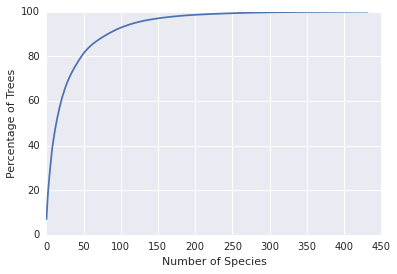

In [162]:
# What does the CDF look like for count of trees by species? What percentage of total plants
# is represented by what percentage of species?
species_pct_of_total = df_good_species.groupby(['qSpecies'])[['qSpecies']]. \
    count() * 100 / len(df_good_species)
df_species_pct_of_total = species_pct_of_total.add_suffix('_count'). \
    sort_values(by="qSpecies_count",ascending=False).reset_index()
# The cumsum function in numpy generates our CDF. Plot it
plt.plot(np.cumsum(df_species_pct_of_total['qSpecies_count']))
plt.xlabel("Number of Species")
plt.ylabel("Percentage of Trees")

You can interpret the above plot like so: pick a value along the x axis, e.g. 50. Move up to find
the point where the plot sits on the y axis (roughly 80). This means that the **top 50 tree species
cover roughly 80% of the total trees managed by FUF.**

In [ ]:
# Heatmap of trees within specific (lat, long) zones? Could we do this by ZIP?